## 0.Import libraries

In [96]:
%%capture

try: 
    import talib
except: 
    !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
    !tar -xzvf ta-lib-0.4.0-src.tar.gz
    %cd ta-lib
    !./configure --prefix=/usr
    !make
    !make install
    !pip install Ta-Lib

In [97]:
import pandas as pd 
import os, sys
import numpy as np 
from dataclasses import dataclass
import random, math, operator
from pprint import pprint
import pickle, gc, itertools
from pathlib import Path
import time, datetime
from collections import *
import matplotlib.pyplot as plt
import talib

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

## 1.define variables

In [98]:
from google.colab import drive    
drive.mount('/content/drive')
base_folder = '/content/drive/MyDrive/MyResearch_FT/14.BERT/gitFolders/' 
currency = 'AUD_USD_M15'
pip = 0.0001
seqlen = 10 
maxlen = 100

gd_result_folder = os.path.join(base_folder, 'result')
gd_mdl_folder = os.path.join(base_folder, 'models')
gd_ref_folder = os.path.join(base_folder, 'refData')
gd_data_folder = os.path.join(base_folder, 'data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
all_models = os.listdir(gd_mdl_folder)

modelname_list = [m for m in all_models if currency in m]
# for file in modelname_list:
#     print(file)

## 2.Evaluation functions

### 2.1 Prediction

In [100]:
def get_predictions_all(mdl, test_dataset): 
    y_pred_maxprice, y_pred_minprice, y_pred_labelbhs = [], [], []
    y_true_maxprice, y_true_minprice, y_true_labelbhs = [], [], []
    ref_max_scale, ref_min_scale, maxprice_ori, minprice_ori = [], [], [], []

    df_prediction = pd.DataFrame(columns=['y_true_labelbhs', 'y_pred_labelbhs', 'y_true_maxprice', 'y_pred_maxprice', 'maxprice_ori', \
                                          'y_true_minprice', 'y_pred_minprice', 'minprice_ori', 'ref_max_scale', 'ref_min_scale'])
    
    for test_batch, (test_inputs, test_targets, ref_data) in enumerate(test_dataset):
        
        prediction_maxprice = [item for sublist in mdl.predict(test_inputs)[0].tolist() for item in sublist]
        prediction_minprice = [item for sublist in mdl.predict(test_inputs)[1].tolist() for item in sublist]
        prediction_labelbhs = mdl.predict(test_inputs)[2].argmax(axis=-1).tolist()

        y_pred_maxprice.extend(prediction_maxprice)
        y_true_maxprice.extend(test_targets['max_price'].numpy())

        y_pred_minprice.extend(prediction_minprice)
        y_true_minprice.extend(test_targets['min_price'].numpy())

        y_pred_labelbhs.extend(prediction_labelbhs)
        y_true_labelbhs.extend(test_targets['label_bhs'].numpy())

        ref_max_scale.extend(ref_data['max_scale'].numpy())
        ref_min_scale.extend(ref_data['min_scale'].numpy())
        maxprice_ori.extend(ref_data['max_ori'].numpy())
        minprice_ori.extend(ref_data['min_ori'].numpy())

    df_prediction['y_true_labelbhs'],  df_prediction['y_pred_labelbhs'] = y_true_labelbhs, y_pred_labelbhs
    df_prediction['y_true_maxprice'], df_prediction['y_pred_maxprice'], df_prediction['maxprice_ori'] = y_true_maxprice, y_pred_maxprice, maxprice_ori
    df_prediction['y_true_minprice'], df_prediction['y_pred_minprice'], df_prediction['minprice_ori'] = y_true_minprice, y_pred_minprice, minprice_ori
    df_prediction['ref_max_scale'], df_prediction['ref_min_scale'] = ref_max_scale, ref_min_scale

    df_prediction['maxprice_prediction'] = df_prediction.apply(lambda r: (r['ref_max_scale']-r['ref_min_scale'])*r['y_pred_maxprice']+r['ref_min_scale'], axis=1)
    df_prediction['minprice_prediction'] = df_prediction.apply(lambda r: (r['ref_max_scale']-r['ref_min_scale'])*r['y_pred_minprice']+r['ref_min_scale'], axis=1)
    
    return df_prediction

### 2.2 Evaluation function for regression model

In [101]:
def evaluate_regression_prediction(y_pred, y_true, model_name, printFlag=True):
    
    errors = np.array(y_pred) - np.array(y_true)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.abs(100*errors/y_true).mean()
    
    if printFlag:
        print(model_name + ':')
        print('Mean Absolute Error: {:.8f}'.format(mae))
        print('Mean Absolute Percentage Error: {:.8f}'.format(mape))
        print('Mean Square Error: {:.8f}'.format(mse))
        print('Root Mean Square Error: {:.8f}'.format(rmse))
        print('')

    return mae, mape, mse, rmse

### 2.3 Evaluation function for classification model

In [102]:
def plot_confusion_matrix(cm, classes, title, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    plt.rcParams["figure.figsize"] = (10, 10)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    
    # plt.savefig(gd_result_folder+title+'.png', bbox_inches = "tight")
    plt.show()

In [103]:
def evaluate_classification_prediction(y_pred, y_true, dict_classes, title):
    
    precision, recall, fscore, support = score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    weighted_accuracy = balanced_accuracy_score(y_true, y_pred)
    
    pred_label = [list(dict_classes.keys())[list(dict_classes.values()).index(l)] for l in y_pred]
    actual_label = [list(dict_classes.keys())[list(dict_classes.values()).index(l)] for l in y_true]
    print(classification_report(actual_label, pred_label, digits=4))
    #print(confusion_matrix(actual_label, pred_label))
    plot_confusion_matrix(confusion_matrix(y_true, y_pred), tuple(list(dict_classes.keys())), title)  # tuple(list(set(pred_label)|set(actual_label)))
    
    return accuracy, precision, recall, fscore, support, weighted_accuracy

### 2.4 Model evaluation

In [104]:
def model_evaluation(model, downstream_test_ds, modelname, df_pred=None): 
    starttime = time.time()
    if df_pred is None:
        df_pred = get_predictions_all(model, downstream_test_ds)
    else:
        ds_tfrecordfilename = ['backtesting 202207 one month data']
    
    print("get result for seqlen %d label_bhs" % seqlen)
    label_bhs_dict = {'buy': 0, 'sell': 1, 'hold': 2}
    accuracy, precision, recall, fscore, support, weighted_accuracy = \
        evaluate_classification_prediction(df_pred['y_pred_labelbhs'].tolist(), df_pred['y_true_labelbhs'].tolist(), label_bhs_dict, modelname)
     
    print("total time spent", time.time()-starttime)
    return df_pred

## 4.testing

### 4.1 read tfrecords

In [105]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def read_dataset_downstream(channel, channel_name, maxlen, seqlen, dstype, batch_size):

    def _parse_seq_function(example_proto):
    
        seq_feature_description = {
            'input_ids': tf.io.FixedLenFeature([], tf.string),
            'segment_ids': tf.io.FixedLenFeature([], tf.string),
            'segment_ids_3num': tf.io.FixedLenFeature([], tf.string), 
            'prices5_scaled': tf.io.FixedLenFeature([], tf.string), 
            'ta_ori': tf.io.FixedLenFeature([], tf.string), 
            'ta_scaled': tf.io.FixedLenFeature([], tf.string), 
            'prices5_min': tf.io.FixedLenFeature([], tf.float32), 
            'prices5_max': tf.io.FixedLenFeature([], tf.float32), 
            'hh_10_ori': tf.io.FixedLenFeature([], tf.float32), 
            'hh_10_scaled': tf.io.FixedLenFeature([], tf.float32), 
            'll_10_ori': tf.io.FixedLenFeature([], tf.float32), 
            'll_10_scaled': tf.io.FixedLenFeature([], tf.float32),
            'label_bhs_ws10_pt10_sl8': tf.io.FixedLenFeature([], tf.int64),             
        }

        features = tf.io.parse_single_example(example_proto, seq_feature_description)
        
        # upstream
        x_input_ids = tf.io.decode_raw(features['input_ids'], tf.int64)
        x_input_ids = tf.reshape(x_input_ids, [maxlen,6])
        x_input_ids_candle, x_input_ids_pos, x_input_ids_die, x_input_ids_cle, x_input_ids_ule, x_input_ids_lle = \
                        tf.split(x_input_ids, 6, axis=1)
        x_input_ids_candle, x_input_ids_pos, x_input_ids_die, x_input_ids_cle, x_input_ids_ule, x_input_ids_lle = \
                        tf.squeeze(x_input_ids_candle, axis=1), tf.squeeze(x_input_ids_pos, axis=1), \
                        tf.squeeze(x_input_ids_die, axis=1), tf.squeeze(x_input_ids_cle, axis=1), \
                        tf.squeeze(x_input_ids_ule, axis=1), tf.squeeze(x_input_ids_lle, axis=1)
        x_segment_ids = tf.io.decode_raw(features['segment_ids_3num'], tf.int64)
        x_segment_ids = tf.reshape(x_segment_ids, [maxlen,])
        x_prices5_scaled = tf.io.decode_raw(features['prices5_scaled'], tf.float32)
        x_prices5_scaled = tf.reshape(x_prices5_scaled, [seqlen,5])
        x_ta_scaled = tf.io.decode_raw(features['ta_scaled'], tf.float32)
        x_ta_scaled = tf.reshape(x_ta_scaled, [seqlen,15])
        
        inputs = {}
        inputs['input_ids_candle'] = x_input_ids_candle
        inputs['input_ids_pos'] = x_input_ids_pos
        inputs['input_ids_die'] = x_input_ids_die
        inputs['input_ids_cle'] = x_input_ids_cle
        inputs['input_ids_ule'] = x_input_ids_ule
        inputs['input_ids_lle'] = x_input_ids_lle

        inputs['segment_ids'] = x_segment_ids
        inputs['prices5_scaled'] = x_prices5_scaled
        inputs['ta_scaled'] = x_ta_scaled

        y_hh = features['hh_10_scaled']
        y_ll = features['ll_10_scaled']
        y_bhs = features['label_bhs_ws10_pt10_sl8']
        
        targets = {}
        targets['max_price'] = y_hh
        targets['min_price'] = y_ll
        targets['label_bhs'] = y_bhs

        ref_data = {}
        ref_data['max_scale'] = features['prices5_max']
        ref_data['min_scale'] = features['prices5_min']
        ref_data['max_ori'] = features['hh_10_ori']
        ref_data['min_ori'] = features['ll_10_ori']
        
        if dstype=='test': 
            return inputs, targets, ref_data
        else: 
            return inputs, targets

    filenames = [os.path.join(channel, c) for c in channel_name]
    print(filenames)
    dataset = tf.data.TFRecordDataset(filenames)

    dataset = dataset.map(_parse_seq_function, num_parallel_calls=AUTOTUNE)
    #dataset = dataset.shuffle(buffer_size=2840000)
    dataset = dataset.prefetch(AUTOTUNE)
    
    if dstype=='test':
        dataset = dataset.batch(batch_size, drop_remainder=False)
    else:
        dataset = dataset.batch(batch_size, drop_remainder=True)

    return dataset

In [106]:
ds_test = read_dataset_downstream(gd_data_folder, [currency+'.tfrecords'], maxlen, seqlen, "test", 1024)

['/content/drive/MyDrive/MyResearch_FT/14.BERT/gitFolders/data/AUD_USD_M15.tfrecords']


### 4.2 load models and predict

In [107]:
model_list = [keras.models.load_model(os.path.join(gd_mdl_folder, modelname)) for modelname in modelname_list]

testing baselineLSTM_1_candlestick_AUD_USD_M15


/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['prices5_scaled', 'ta_scaled'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/29 [==============================] - 2s 70ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.0000    0.0000    0.0000      2305
        hold     0.2166    1.0000    0.3561      1307
        sell     0.0000    0.0000    0.0000      2422

    accuracy                         0.2166      6034
   macro avg     0.0722    0.3333    0.1187      6034
weighted avg     0.0469    0.2166    0.0771      6034



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classificat

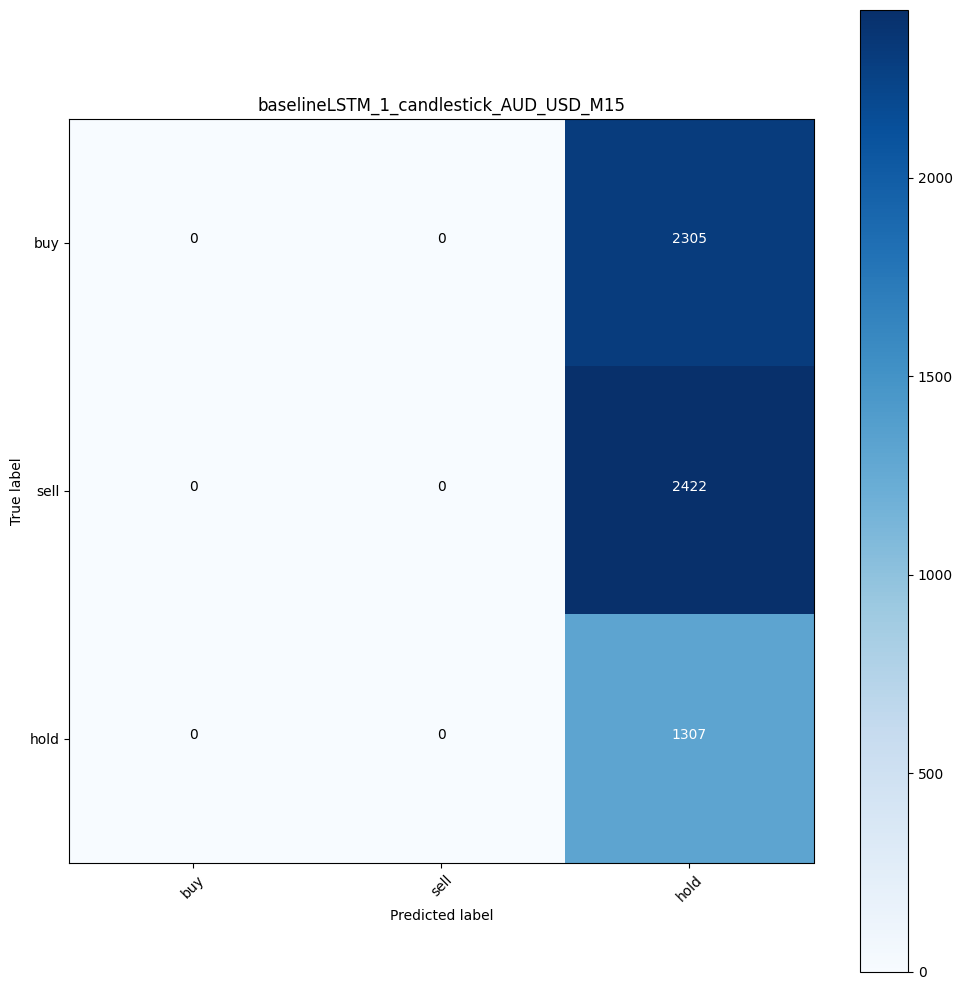

total time spent 52.43864607810974
testing baselineLSTM_4_price5_AUD_USD_M15


/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['input_ids_candle', 'input_ids_pos', 'input_ids_die', 'input_ids_cle', 'input_ids_ule', 'input_ids_lle', 'segment_ids', 'ta_scaled'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/29 [==============================] - 1s 17ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.3853    0.5258    0.4447      2305
        hold     0.2702    0.3382    0.3004      1307
        sell     0.4097    0.2118    0.2793      2422

    accuracy                         0.3591      6034
   macro avg     0.3551    0.3586    0.3414      6034
weighted avg     0.3702    0.3591    0.3470      6034



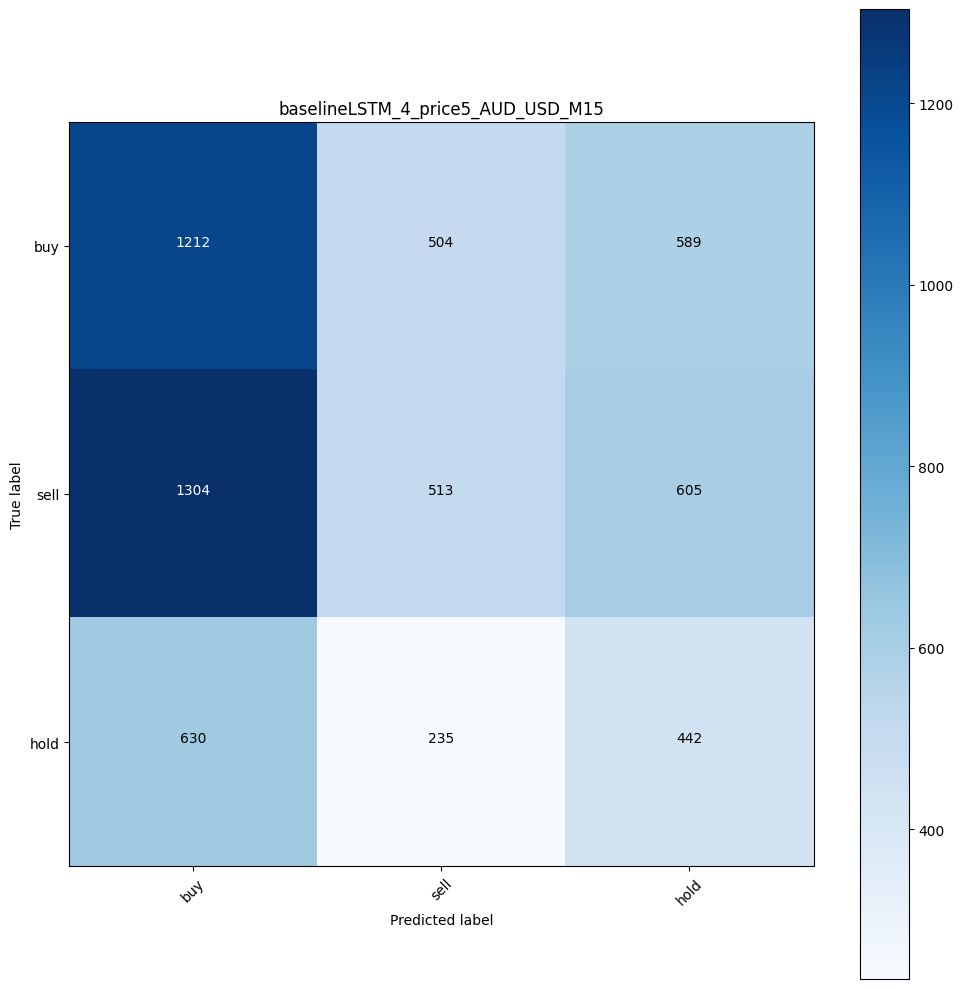

total time spent 17.272197008132935
testing baselineLSTM_5_TA_AUD_USD_M15


/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['input_ids_candle', 'input_ids_pos', 'input_ids_die', 'input_ids_cle', 'input_ids_ule', 'input_ids_lle', 'segment_ids', 'prices5_scaled'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/29 [==============================] - 1s 18ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.3891    0.4382    0.4122      2305
        hold     0.2490    0.2494    0.2492      1307
        sell     0.4119    0.3621    0.3854      2422

    accuracy                         0.3668      6034
   macro avg     0.3500    0.3499    0.3489      6034
weighted avg     0.3679    0.3668    0.3661      6034



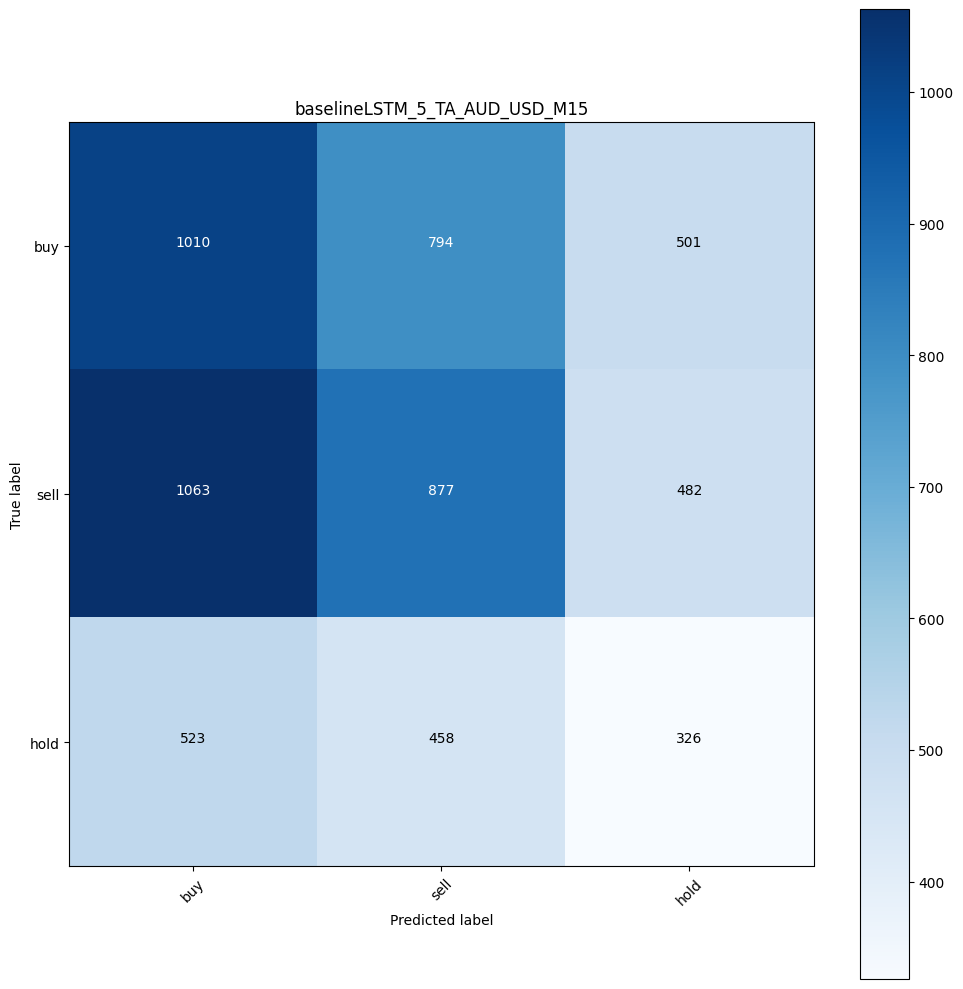

total time spent 21.54150152206421
testing baselineLSTM_6_price5_TA_AUD_USD_M15


/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['input_ids_candle', 'input_ids_pos', 'input_ids_die', 'input_ids_cle', 'input_ids_ule', 'input_ids_lle', 'segment_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/29 [==============================] - 1s 21ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.3935    0.4230    0.4077      2305
        hold     0.2560    0.2533    0.2546      1307
        sell     0.3951    0.3691    0.3816      2422

    accuracy                         0.3646      6034
   macro avg     0.3482    0.3485    0.3480      6034
weighted avg     0.3643    0.3646    0.3641      6034



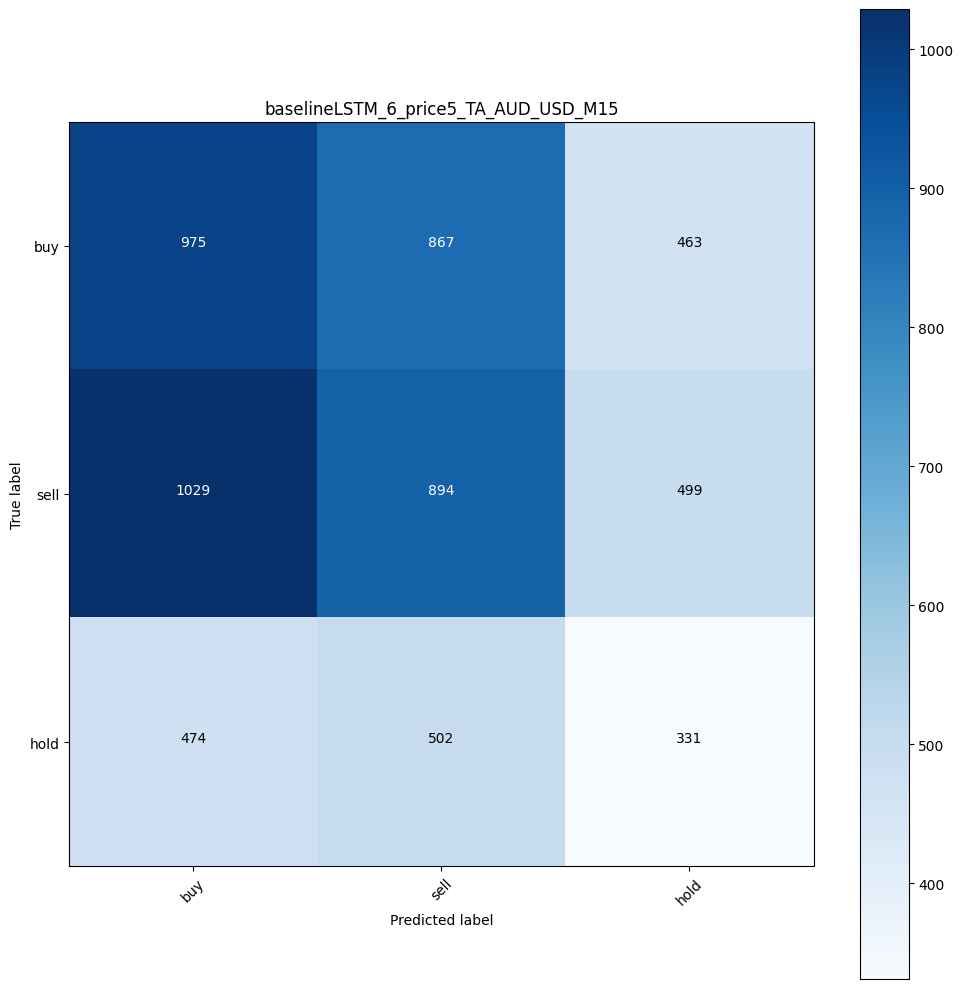

total time spent 41.688084840774536
testing baselineLSTM_2_candlestick_price5_TA_AUD_USD_M15
29/29 [==============================] - 2s 75ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.3838    0.4443    0.4118      2305
        hold     0.2801    0.2884    0.2842      1307
        sell     0.4064    0.3390    0.3697      2422

    accuracy                         0.3682      6034
   macro avg     0.3568    0.3572    0.3552      6034
weighted avg     0.3704    0.3682    0.3673      6034



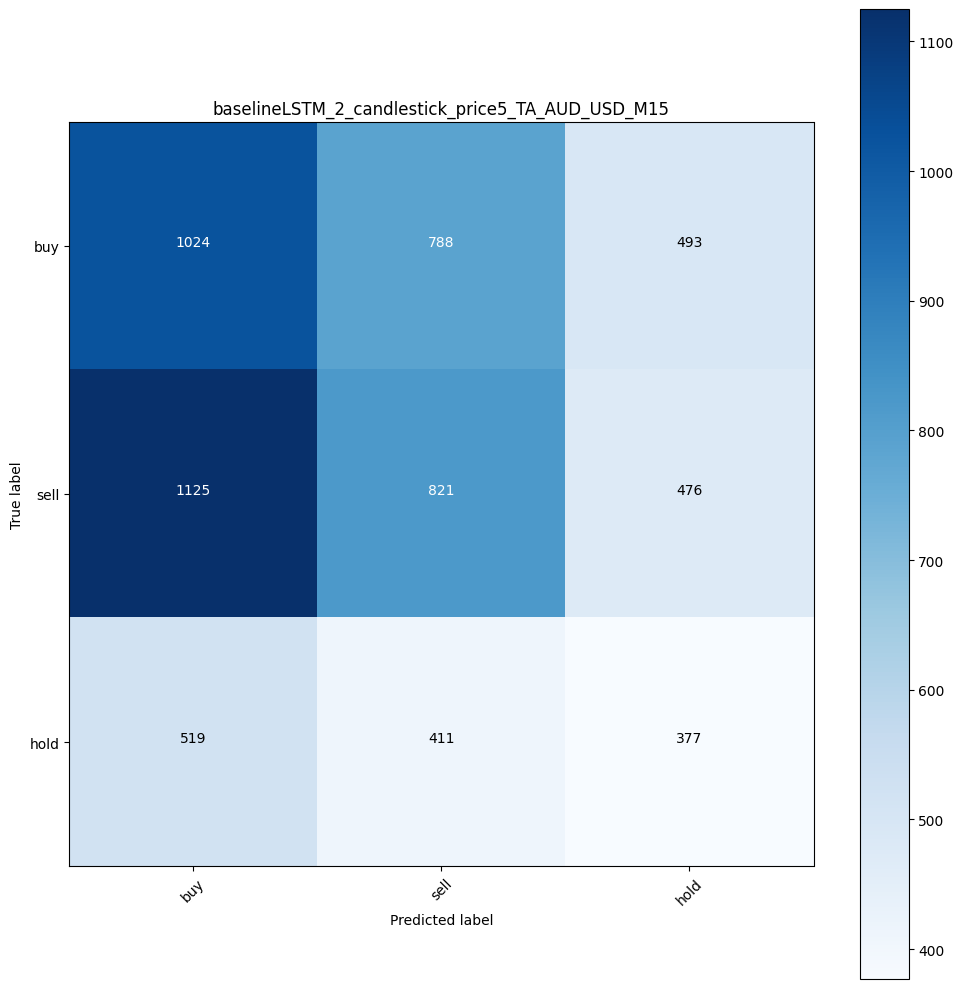

total time spent 82.66038465499878
testing baselineLSTM_3_candlestick_price5_AUD_USD_M15


/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['ta_scaled'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/29 [==============================] - 2s 74ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.3753    0.3501    0.3623      2305
        hold     0.2567    0.3650    0.3014      1307
        sell     0.4195    0.3509    0.3822      2422

    accuracy                         0.3537      6034
   macro avg     0.3505    0.3553    0.3486      6034
weighted avg     0.3674    0.3537    0.3571      6034



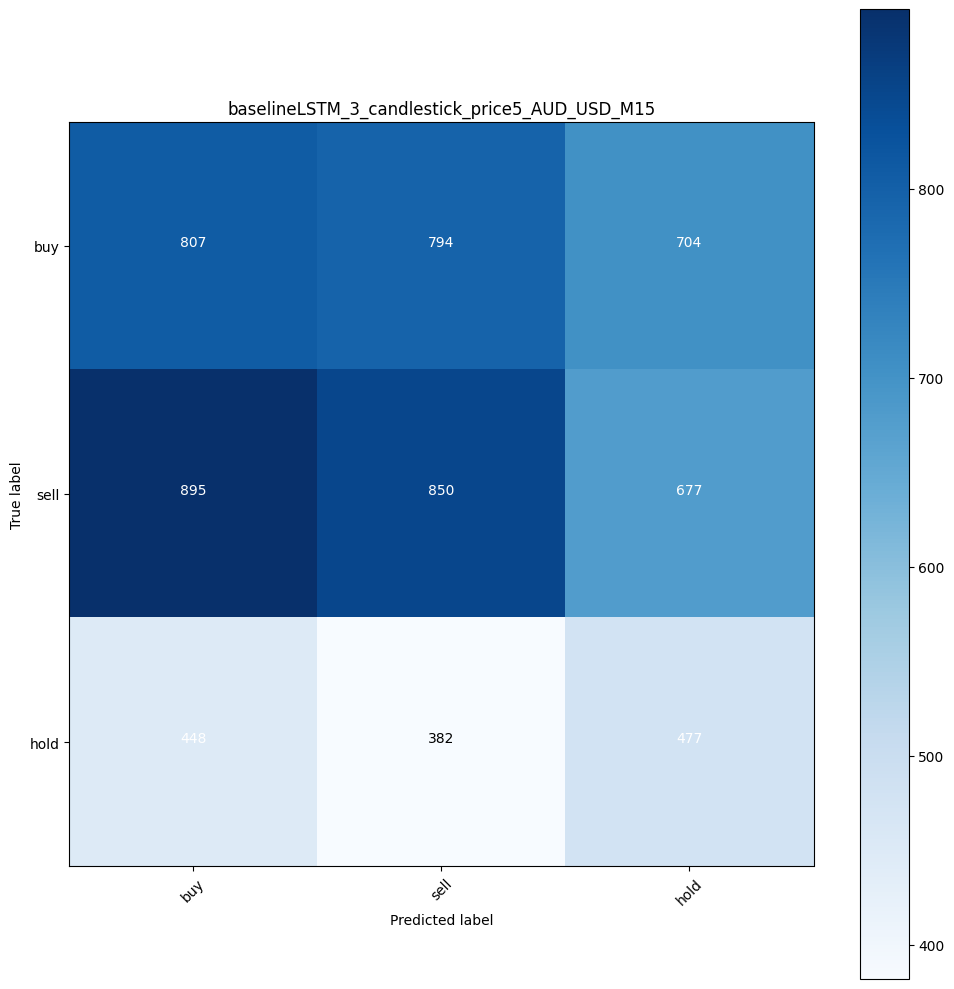

total time spent 82.62283515930176
testing tradingBERT_FeatExtraction_3_candlestick_price5_AUD_USD_M15


/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['ta_scaled'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/29 [==============================] - 7s 239ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4206    0.5783    0.4870      2305
        hold     0.3782    0.4644    0.4169      1307
        sell     0.4722    0.2457    0.3232      2422

    accuracy                         0.4201      6034
   macro avg     0.4237    0.4295    0.4090      6034
weighted avg     0.4321    0.4201    0.4061      6034



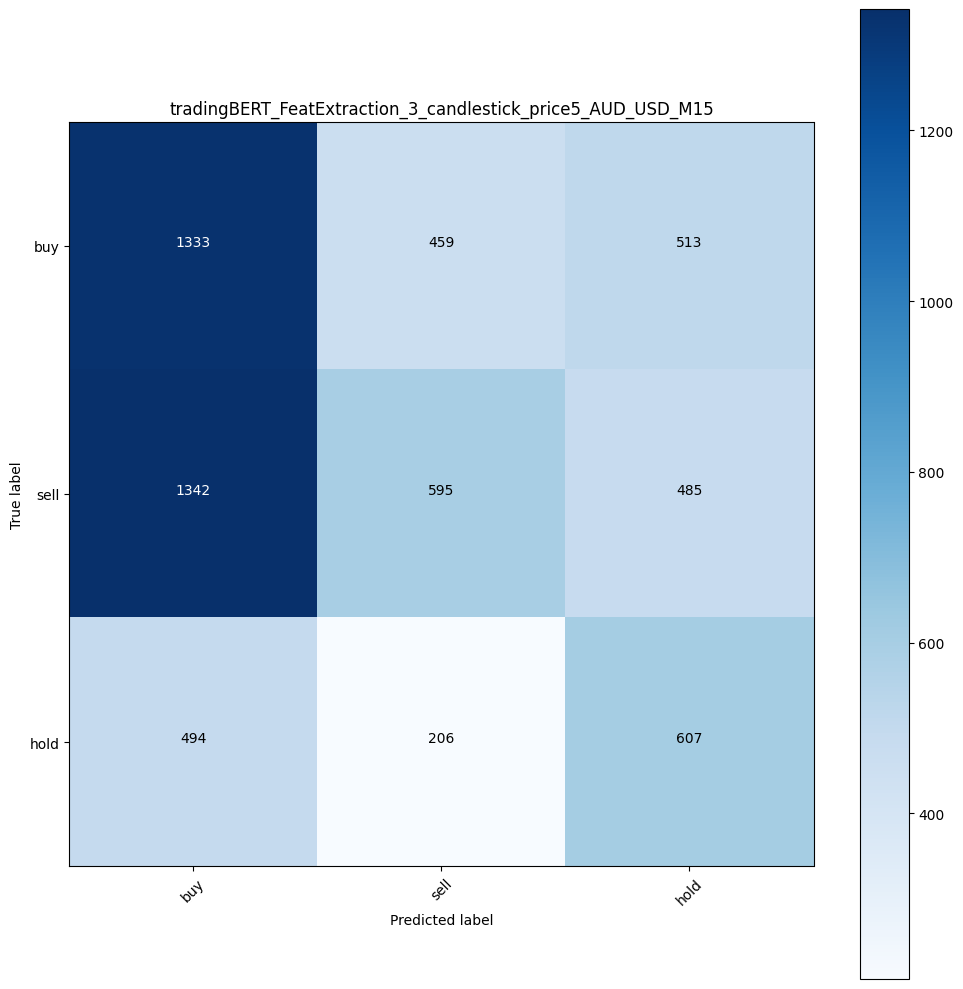

total time spent 202.6366891860962
testing tradingBERT_FeatExtraction_2_candlestick_price5_TA_AUD_USD_M15
29/29 [==============================] - 5s 173ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4098    0.6360    0.4985      2305
        hold     0.3866    0.4239    0.4044      1307
        sell     0.4463    0.1887    0.2652      2422

    accuracy                         0.4105      6034
   macro avg     0.4142    0.4162    0.3894      6034
weighted avg     0.4194    0.4105    0.3845      6034



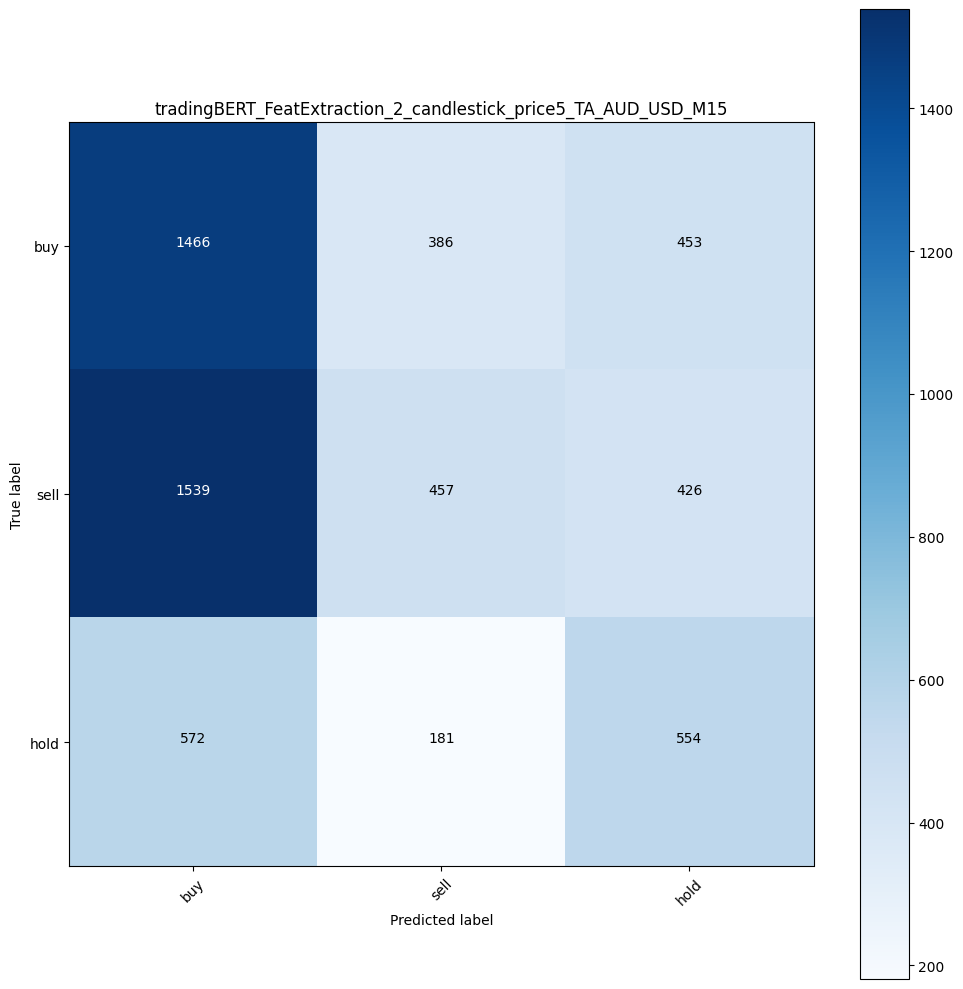

total time spent 158.73093557357788
testing tradingBERT_FeatExtraction_1_candlestick_AUD_USD_M15


/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['prices5_scaled', 'ta_scaled'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/29 [==============================] - 5s 166ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4060    0.6547    0.5012      2305
        hold     0.4159    0.3933    0.4042      1307
        sell     0.4496    0.2007    0.2775      2422

    accuracy                         0.4158      6034
   macro avg     0.4238    0.4162    0.3943      6034
weighted avg     0.4256    0.4158    0.3904      6034



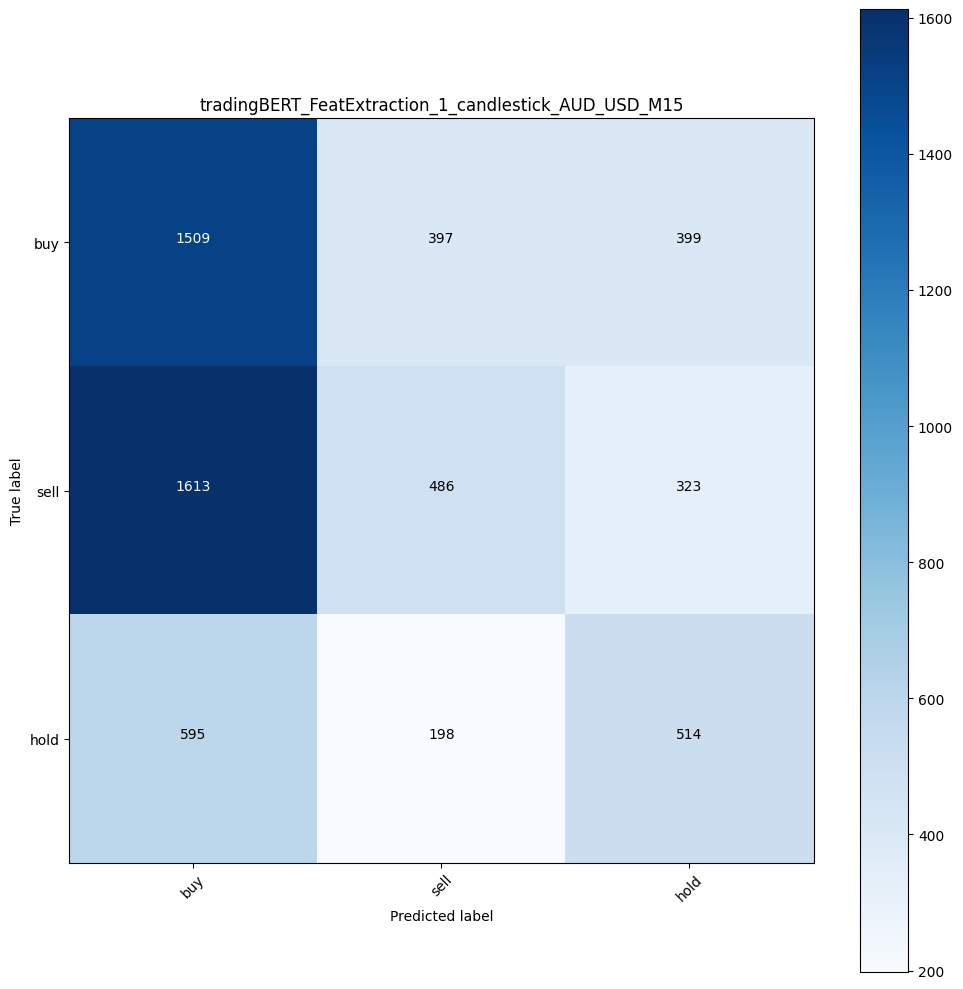

total time spent 202.6874611377716
testing tradingBERT_Ftuning_3_candlestick_price5_AUD_USD_M15


/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['ta_scaled'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/29 [==============================] - 7s 221ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4048    0.6108    0.4869      2305
        hold     0.3960    0.4239    0.4095      1307
        sell     0.4538    0.2168    0.2934      2422

    accuracy                         0.4122      6034
   macro avg     0.4182    0.4172    0.3966      6034
weighted avg     0.4226    0.4122    0.3925      6034



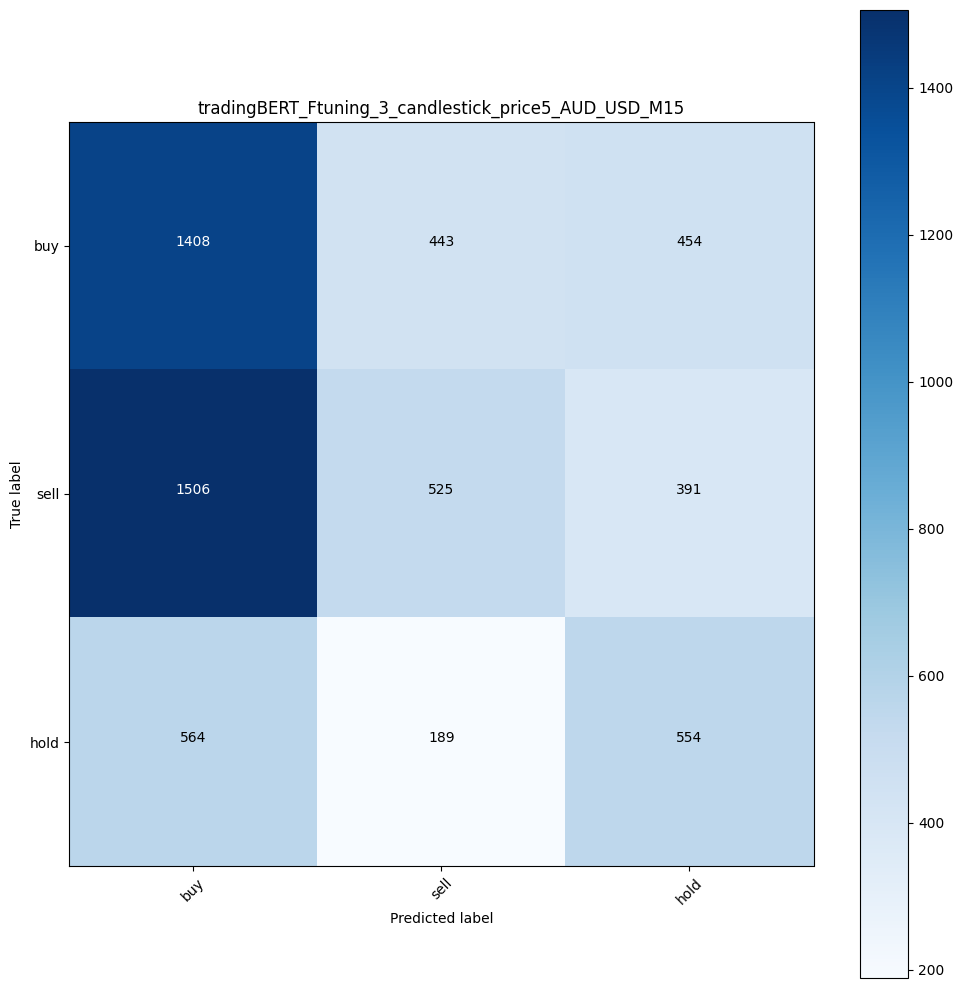

total time spent 142.66886830329895
testing tradingBERT_Ftuning_2_candlestick_price5_TA_AUD_USD_M15
29/29 [==============================] - 7s 243ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4138    0.7132    0.5237      2305
        hold     0.4059    0.4292    0.4173      1307
        sell     0.4580    0.1284    0.2006      2422

    accuracy                         0.4170      6034
   macro avg     0.4259    0.4236    0.3805      6034
weighted avg     0.4298    0.4170    0.3710      6034



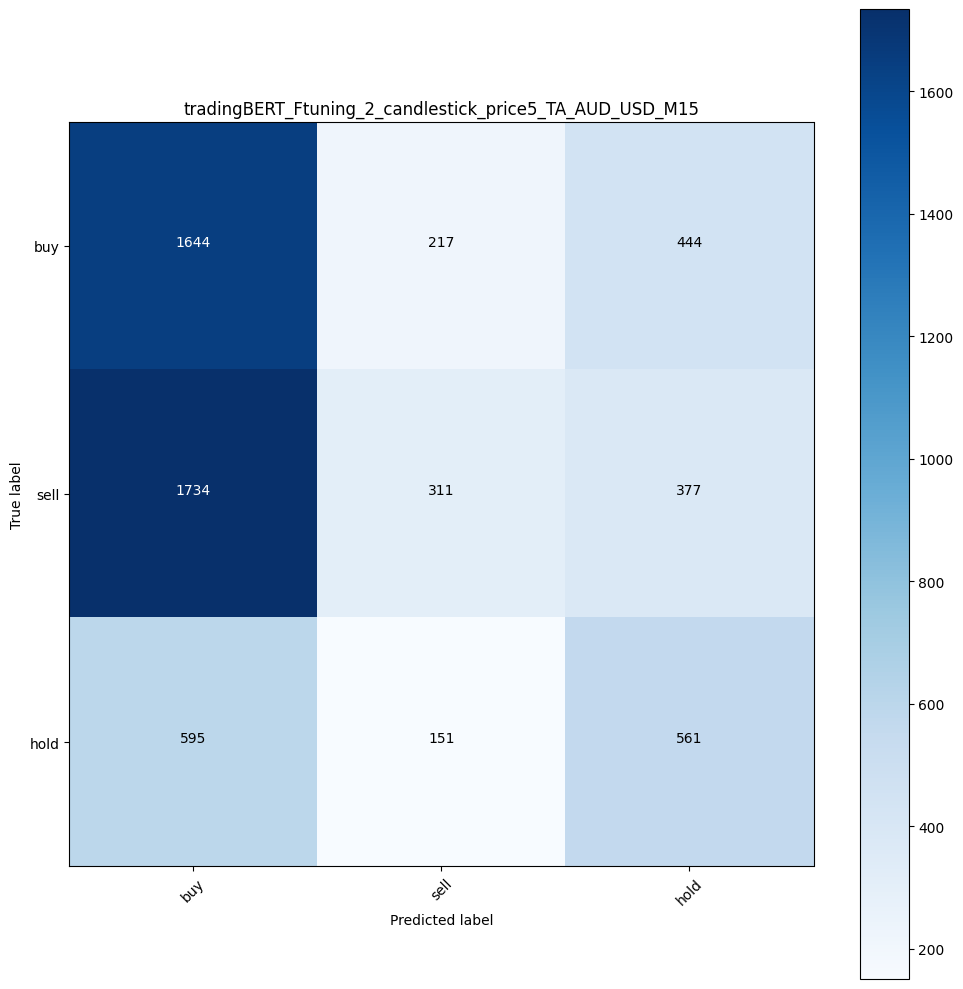

total time spent 202.64654183387756
testing tradingBERT_Ftuning_1_candlestick_AUD_USD_M15


/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['prices5_scaled', 'ta_scaled'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/29 [==============================] - 7s 240ms/step
get result for seqlen 10 label_bhs
              precision    recall  f1-score   support

         buy     0.4129    0.6161    0.4944      2305
        hold     0.4056    0.4009    0.4032      1307
        sell     0.4582    0.2465    0.3205      2422

    accuracy                         0.4211      6034
   macro avg     0.4256    0.4212    0.4061      6034
weighted avg     0.4295    0.4211    0.4049      6034



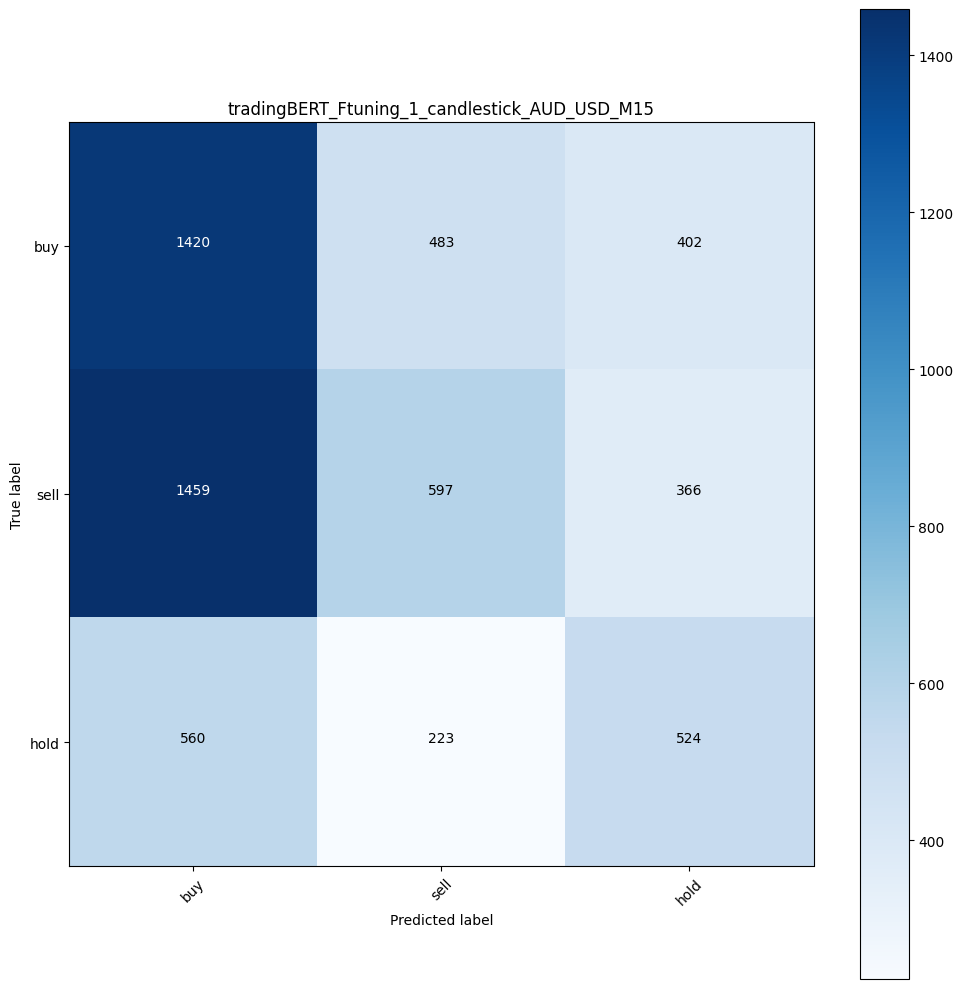

total time spent 155.6474974155426


In [108]:
for idx, model in enumerate(model_list): 
    modelname = modelname_list[idx].replace('.h5', '')
    print("testing", modelname)
    _ = model_evaluation(model, ds_test, modelname)


In [109]:
assert = False

SyntaxError: ignored

## 5.backtesting

### 5.1 Basic functions

In [ ]:
def getHandL_next_N_window(df, windowSize, pips=0.0001):
    def idx_max(x):
        return x.index.values[np.argmax(x.values)]
    def idx_min(x):
        return x.index.values[np.argmin(x.values)]
    df_max_next = df['high'].rolling(windowSize).agg(['max', idx_max]).shift(-1*windowSize)
    df_min_next = df['low'].rolling(windowSize).agg(['min', idx_min]).shift(-1*windowSize)
    df_merged = pd.concat([df, df_max_next, df_min_next], axis=1)
    df_merged = df_merged.rename(columns={'max': 'hh_next_'+str(windowSize), \
                                          'idx_max': 'hh_next_idx_'+str(windowSize), \
                                          'min': 'll_next_'+str(windowSize), \
                                          'idx_min': 'll_next_idx_'+str(windowSize)})
    
    df_merged['hh_diff_'+str(windowSize)]=df_merged.apply(lambda row: (row['hh_next_'+str(windowSize)]-row['close'])/pips, axis=1)
    df_merged['ll_diff_'+str(windowSize)]=df_merged.apply(lambda row: (row['close']-row['ll_next_'+str(windowSize)])/pips, axis=1)

    return df_merged

In [ ]:
def get_labels_buy_hold_sell(df, windowSize, pips, pt, sl):
    if ('hh_diff_'+str(windowSize) not in list(df.columns)) or ('ll_diff_'+str(windowSize) not in list(df.columns)):
        df = getHandL_next_N_window(df, windowSize)
        
    conditions = [
        (df['hh_diff_'+str(windowSize)]>pt) & (df['ll_diff_'+str(windowSize)]<sl),
        (df['hh_diff_'+str(windowSize)]>pt) & (df['ll_diff_'+str(windowSize)]>sl)
                & (df['hh_next_idx_'+str(windowSize)]<df['ll_next_idx_'+str(windowSize)]),
        (df['ll_diff_'+str(windowSize)]>pt) & (df['hh_diff_'+str(windowSize)]<sl),
        (df['ll_diff_'+str(windowSize)]>pt) & (df['hh_diff_'+str(windowSize)]>sl)
                & (df['ll_next_idx_'+str(windowSize)]<df['hh_next_idx_'+str(windowSize)]),
    ]
    label_dict = {0:'buy', 1:'sell', 2:'hold'}

    #labels = ['buy','buy','sell','sell']
    labels = [0, 0, 1, 1]
    df['label_bhs_ws'+str(windowSize)+'_pt'+str(pt)+'_sl'+str(sl)] = np.select(conditions, labels, default=2) # hold
    df.drop(columns=['hh_next_idx_'+str(windowSize), 'll_next_idx_'+str(windowSize), 'hh_diff_'+str(windowSize), 'll_diff_'+str(windowSize)], inplace=True)
    
    return df

In [ ]:
def getTalibIndicators(df): 
    high = df.high
    low = df.low
    open = df.open
    close = df.close 
    
    df['macd'], df['macd_signal'], df['macd_hist'] = talib.MACD(df['close'], 12, 26, 9)
    
    for i in range(10, 50, 10):
        df['RSI_'+str(i)] = talib.RSI(close, timeperiod=i)
        df['WILLR_'+str(i)] = talib.WILLR(high, low, close, timeperiod=i) 
        df['EMA_'+str(i)] = talib.EMA(close, timeperiod=i) 
    
    return df

In [ ]:
def unpickleData(file):
    print("start processing data ...")
    data_dict = {}
        
    if not os.path.isfile(file):
        print(file, "does not exist.")
    else:
        print(file, "... unpacking ...")
        with open(file, "rb") as fp:  
            unpickler = pickle.Unpickler(fp)
            try: 
                data_dict.update(unpickler.load())
            except: 
                pass
            fp.close()
    
    print("len(data_dict)", len(data_dict))
    return data_dict

In [ ]:
def getCandleElements(df_tmp, direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict):

    df_tmp['direction'] = 0 
    df_tmp.loc[df_tmp['close'] > df_tmp['open'], 'direction'] = 1
    df_tmp.loc[df_tmp['close'] < df_tmp['open'], 'direction'] = -1

    df_tmp['candle_len'] = abs(df_tmp['close']-df_tmp['open'])/df_tmp['pip']
    df_tmp['candle_len'] = df_tmp['candle_len'].apply(lambda r: round(r, 0)).astype(int)

    df_tmp['upper_len'] = 0
    df_tmp.loc[df_tmp['close'] > df_tmp['open'], 'upper_len'] = abs(df_tmp['high']-df_tmp['close'])/df_tmp['pip']
    df_tmp.loc[df_tmp['close'] < df_tmp['open'], 'upper_len'] = abs(df_tmp['high']-df_tmp['open'])/df_tmp['pip']
    df_tmp['upper_len'] = df_tmp['upper_len'].apply(lambda r: round(r, 0)).astype(int)

    df_tmp['lower_len'] = 0
    df_tmp.loc[df_tmp['close'] > df_tmp['open'], 'lower_len'] = abs(df_tmp['low']-df_tmp['open'])/df_tmp['pip']
    df_tmp.loc[df_tmp['close'] < df_tmp['open'], 'lower_len'] = abs(df_tmp['low']-df_tmp['close'])/df_tmp['pip']
    df_tmp['lower_len'] = df_tmp['lower_len'].apply(lambda r: round(r, 0)).astype(int)

    df_tmp['pos_low'] = df_tmp['low']/df_tmp['pip']
    df_tmp['pos_low'] = df_tmp['pos_low'].apply(lambda r: round(r, 0)).astype(int)
    
    df_tmp['direction_encoded'] = df_tmp['direction'].apply(lambda row: direction_encode_dict[int(row)])
    df_tmp['candle_len_encoded'] = df_tmp['candle_len'].apply(lambda row: candlepiece_encode_dict[int(row)])
    df_tmp['upper_len_encoded'] = df_tmp['upper_len'].apply(lambda row: candlepiece_encode_dict[int(row)])
    df_tmp['lower_len_encoded'] = df_tmp['lower_len'].apply(lambda row: candlepiece_encode_dict[int(row)])
    df_tmp['pos_low_encoded'] = df_tmp['pos_low'].apply(lambda row: pos_encode_dict[int(row)])
    
    df_tmp['candlestick_encoded'] = df_tmp.apply(lambda row: \
        candlestick_encode_dict['candlestick_encode_dict'][str([int(i) for i in row[['candle_len', 'upper_len', 'lower_len', 'direction']].values.tolist()])], axis=1)
    
    return df_tmp

### 5.2 test

In [ ]:
def backtesting(seqlen, df_btesting, savepath_model, modelname, result_df, direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict):

    input_row_size = 40 + seqlen         
    inputs = deque(maxlen=input_row_size)

    maxIndex = max(df_btesting.index.tolist())

    ta_columns = ['macd','macd_signal','macd_hist','RSI_10','WILLR_10','EMA_10','RSI_20','WILLR_20',
                'EMA_20','RSI_30','WILLR_30','EMA_30','RSI_40','WILLR_40','EMA_40']

    #load model
    model = keras.models.load_model(savepath_model)

    index_list, prediction_list = [], []
    for index,row in df_btesting.iterrows():

        inputs.append([row['open'], row['high'], row['low'], row['close'], row['pip']])
        
        if (len(inputs) == input_row_size) & (index <= maxIndex-seqlen):
            df_inputs = pd.DataFrame(inputs)
            df_inputs.columns = ['open', 'high', 'low', 'close', 'pip']

            # preprocess data 
            df_inputs['avg'] = df_inputs.apply(lambda r: (r['open']+r['high']+r['low']+r['close'])/4, axis=1)
            df_inputs = getTalibIndicators(df_inputs)    
            df_inputs = getCandleElements(df_inputs, direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict)        
            df_inputs = df_inputs.tail(seqlen)
            
            if df_inputs.isnull().values.any(): 
                print(df_inputs)
            assert df_inputs.isnull().values.any()==False

            candlestick_encoded = df_inputs[['candlestick_encoded', 'pos_low_encoded', 'direction_encoded',
                                        'candle_len_encoded', 'upper_len_encoded', 'lower_len_encoded']].values.tolist()
            input_ids = [[2]*6] + candlestick_encoded + [[3]*6]
            segment_ids_3num = [1] * len(input_ids)

            n_pad = config.maxlen - len(input_ids)
            input_ids.extend([[0]*6] * n_pad)
            segment_ids_3num.extend([0] * n_pad) 

            x_input_ids = np.array(input_ids).astype('int64')       
            x_input_ids_candle, x_input_ids_pos, x_input_ids_die, x_input_ids_cle, x_input_ids_ule, x_input_ids_lle = \
                                np.split(x_input_ids, 6, axis=1)        
            
            scaler = MinMaxScaler()       

            x_inputs = {}
            x_inputs['input_ids_candle'] = np.expand_dims(x_input_ids_candle, 0)
            x_inputs['input_ids_pos'] = np.expand_dims(x_input_ids_pos, 0)
            x_inputs['input_ids_die'] = np.expand_dims(x_input_ids_die, 0)
            x_inputs['input_ids_cle'] = np.expand_dims(x_input_ids_cle, 0)
            x_inputs['input_ids_ule'] = np.expand_dims(x_input_ids_ule, 0)
            x_inputs['input_ids_lle'] = np.expand_dims(x_input_ids_lle, 0)
            x_inputs['segment_ids'] = np.expand_dims(np.array(segment_ids_3num).astype('int64'), 0)
            x_inputs['prices5_scaled'] = np.expand_dims(scaler.fit_transform(df_inputs[['open', 'high', 'low', 'close', 'avg']]), 0)
            x_inputs['ta_scaled'] = np.expand_dims(scaler.fit_transform(df_inputs[ta_columns]), 0)

            prices5_min = min(df_inputs[['open', 'high', 'low', 'close', 'avg']].min())
            prices5_max = max(df_inputs[['open', 'high', 'low', 'close', 'avg']].max())

            prediction_maxprice = model.predict(x_inputs)[0][0][0]
            prediction_minprice = model.predict(x_inputs)[1][0][0]
            prediction_labelbhs = model.predict(x_inputs)[2].argmax(axis=-1).tolist()[0]

            inverse_maxprice = (prices5_max-prices5_min)*prediction_maxprice+prices5_min
            inverse_minprice = (prices5_max-prices5_min)*prediction_minprice+prices5_min

            index_list.append(index)
            prediction_list.append([prediction_maxprice, prediction_minprice, prediction_labelbhs, inverse_maxprice, inverse_minprice])

    df_btesting.loc[index_list, ['prediction_maxprice_'+str(seqlen), 'prediction_minprice_'+str(seqlen), 'prediction_labelbhs_'+str(seqlen), 'inverse_maxprice_'+str(seqlen), 'inverse_minprice_'+str(seqlen)]] = prediction_list      
    
    df_pred = df_btesting[['datetime', 'prediction_labelbhs_'+str(seqlen), 'label_bhs_ws10_pt10_sl8', 'inverse_maxprice_'+str(seqlen), 'hh_next_10', 'inverse_minprice_'+str(seqlen), 'll_next_10']]
    df_pred = df_pred[df_pred['y_pred_labelbhs'].notna()]

    downstream_test=None
    result_df, df_pred = model_evaluation(model, savepath_model, result_df, downstream_test, seqlen, modelname=modelname, df_pred=df_pred)
    df_pred.to_csv(gd_result_folder+'df_prediction_'+modelname+'.csv')
    
    return result_df

In [ ]:
df = pd.read_csv(os.path.join(gd_data_folder, currency+'.csv'))
df['pip'] = pip

df = get_labels_buy_hold_sell(df, windowSize=10, pips=pip, pt=10, sl=8) 

data_dict = unpickleData(os.path.join(gd_ref_folder, currency+'_dictionary.txt'))
pos_encode_dict = data_dict['pos_encode_dict']
candlepiece_encode_dict = data_dict['candlepiece_encode_dict']
direction_encode_dict = data_dict['direction_encode_dict']

candlestick_encode_dict = unpickleData(os.path.join(gd_ref_folder, 'candlestick_dictionary.txt'))

In [ ]:
# preprocess data 
df['avg'] = df.apply(lambda r: (r['open']+r['high']+r['low']+r['close'])/4, axis=1)
df = getTalibIndicators(df)    
df = getCandleElements(df, direction_encode_dict, candlepiece_encode_dict, pos_encode_dict, candlestick_encode_dict)        
df = df.iloc[50:-20] # remove possible null 
df = df.reset_index(drop=True)

if df.isnull().values.any(): 
    print(df)
assert df.isnull().values.any()==False

In [ ]:
batch_column_name = ['candlestick_encoded', 'input_ids', 'segment_ids', 'segment_ids_3num', 'prices5_ori', \
                       'prices5_scaled', 'ta_ori', 'ta_scaled', 'prices5_min', 'prices5_max', \
                       'hh_10_ori', 'hh_10_scaled', 'll_10_ori', 'll_10_scaled', 'label_bhs_ws10_pt10_sl8']
ta_columns = ['macd','macd_signal','macd_hist','RSI_10','WILLR_10','EMA_10','RSI_20','WILLR_20',
              'EMA_20','RSI_30','WILLR_30','EMA_30','RSI_40','WILLR_40','EMA_40']

In [ ]:
batch = []
for i in range(len(df)-seqlen):
    df_tmp = df.loc[i:i+seqlen-1]
    assert len(df_tmp)==seqlen

    scaler = MinMaxScaler()
    
    candlestick_encoded = df_tmp[['candlestick_encoded', 'pos_low_encoded', 'direction_encoded',
                                'candle_len_encoded', 'upper_len_encoded', 'lower_len_encoded']].values.tolist()
    input_ids = [[2]*6] + candlestick_encoded + [[3]*6]
    segment_ids = [0] * maxlen
    segment_ids_3num = [1] * len(input_ids)

    n_pad = maxlen - len(input_ids)
    input_ids.extend([[0]*6] * n_pad)
    segment_ids_3num.extend([0] * n_pad) 

    prices5_min = min(df_tmp[['open', 'high', 'low', 'close', 'avg']].min())
    prices5_max = max(df_tmp[['open', 'high', 'low', 'close', 'avg']].max())
    dt_tmp = [input_ids, 
            segment_ids, 
            segment_ids_3num, 
                
            df_tmp[['open', 'high', 'low', 'close', 'avg']].values.tolist(), 
            scaler.fit_transform(df_tmp[['open', 'high', 'low', 'close', 'avg']]), 
            
            df_tmp[ta_columns].values.tolist(), 
            scaler.fit_transform(df_tmp[ta_columns]),
                
            prices5_min, #min(df_tmp[['open', 'high', 'low', 'close', 'avg']].min()),
            prices5_max, #max(df_tmp[['open', 'high', 'low', 'close', 'avg']].max()),
                
            df_tmp.tail(1)[['hh_next_10']].values[0][0],
            (df_tmp.tail(1)[['hh_next_10']].values[0][0]-prices5_min)/(prices5_max-prices5_min), 
            df_tmp.tail(1)[['ll_next_10']].values[0][0],
            (df_tmp.tail(1)[['ll_next_10']].values[0][0]-prices5_min)/(prices5_max-prices5_min), 
                
            df_tmp.tail(1)[['label_bhs_ws10_pt10_sl8']].values[0][0]
        ]
    batch.append(dt_tmp)

In [ ]:
batch_transpose = [list(x) for x in list(zip(*batch))]
    
input_ids = np.array(batch_transpose[1]).astype('int64')
segment_ids = np.array(batch_transpose[2]).astype('int64')
segment_ids_3num = np.array(batch_transpose[3]).astype('int64')
prices5_ori = np.array(batch_transpose[4]).astype('float32')
prices5_scaled = np.array(batch_transpose[5]).astype('float32')
ta_ori = np.array(batch_transpose[6]).astype('float32')
ta_scaled = np.array(batch_transpose[7]).astype('float32')
prices5_min = np.array(batch_transpose[8]).astype('float32')
prices5_max = np.array(batch_transpose[9]).astype('float32')
hh_10_ori = np.array(batch_transpose[10]).astype('float32')
hh_10_scaled = np.array(batch_transpose[11]).astype('float32')
ll_10_ori = np.array(batch_transpose[12]).astype('float32')
ll_10_scaled = np.array(batch_transpose[13]).astype('float32')
label_bhs_ws10_pt10_sl8 = np.array(batch_transpose[14]).astype('int64')

x_input_ids_candle, x_input_ids_pos, x_input_ids_die, x_input_ids_cle, x_input_ids_ule, x_input_ids_lle = \
                        tf.split(input_ids, 6, axis=1)